# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

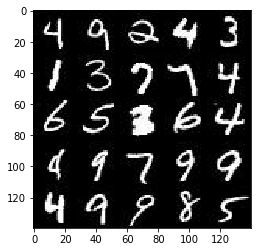

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

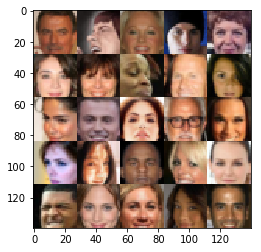

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None,image_width,image_height,image_channels], name='Real_Input')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='Z_Input')
    learning_rate = tf.placeholder(tf.float32, name='Learning_Rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/paperspace/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/paperspace/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/paperspace/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/paperspace/anaconda3/lib/python3.6/sit

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.15
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x364
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        # 7x7x128
        
       
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAoutT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        alpha=0.15  
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')

        # 28x28x5 now
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()


### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    image_channels=1
    if data_image_mode =="RGB":
        image_channels = 3


    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], image_channels, 200)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)

   

    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                # batch images
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], image_channels)
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z,lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images,lr:learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess=sess, n_images=30, input_z=input_z, out_channel_dim=image_channels, image_mode=data_image_mode)


      # saver.save(sess, './checkpoints/generator.ckpt')

    #with open('samples.pkl', 'wb') as f:
     #   pkl.dump(samples, f)

    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.6375... Generator Loss: 0.0934
Epoch 1/2... Discriminator Loss: 1.8358... Generator Loss: 0.3299
Epoch 1/2... Discriminator Loss: 1.5967... Generator Loss: 0.4982
Epoch 1/2... Discriminator Loss: 1.6385... Generator Loss: 0.4674
Epoch 1/2... Discriminator Loss: 1.9681... Generator Loss: 0.4170
Epoch 1/2... Discriminator Loss: 1.9625... Generator Loss: 0.4360
Epoch 1/2... Discriminator Loss: 1.2807... Generator Loss: 0.7186
Epoch 1/2... Discriminator Loss: 1.5085... Generator Loss: 0.5605
Epoch 1/2... Discriminator Loss: 1.6016... Generator Loss: 0.5702
Epoch 1/2... Discriminator Loss: 1.3164... Generator Loss: 0.6305


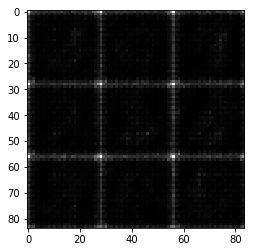

Epoch 1/2... Discriminator Loss: 1.5797... Generator Loss: 0.5180
Epoch 1/2... Discriminator Loss: 1.6530... Generator Loss: 0.5303
Epoch 1/2... Discriminator Loss: 1.4637... Generator Loss: 0.5666
Epoch 1/2... Discriminator Loss: 1.5469... Generator Loss: 0.5622
Epoch 1/2... Discriminator Loss: 1.6431... Generator Loss: 0.5388
Epoch 1/2... Discriminator Loss: 1.5783... Generator Loss: 0.5693
Epoch 1/2... Discriminator Loss: 1.5110... Generator Loss: 0.5780
Epoch 1/2... Discriminator Loss: 1.5405... Generator Loss: 0.5589
Epoch 1/2... Discriminator Loss: 1.5658... Generator Loss: 0.5451
Epoch 1/2... Discriminator Loss: 1.4930... Generator Loss: 0.5943


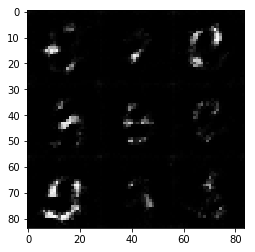

Epoch 1/2... Discriminator Loss: 1.4997... Generator Loss: 0.5678
Epoch 1/2... Discriminator Loss: 1.4972... Generator Loss: 0.5655
Epoch 1/2... Discriminator Loss: 1.4907... Generator Loss: 0.5698
Epoch 1/2... Discriminator Loss: 1.4605... Generator Loss: 0.6134
Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 0.6362
Epoch 1/2... Discriminator Loss: 1.4684... Generator Loss: 0.5959
Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 0.5984
Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 0.6779
Epoch 1/2... Discriminator Loss: 1.3415... Generator Loss: 0.6723
Epoch 1/2... Discriminator Loss: 1.3898... Generator Loss: 0.6212


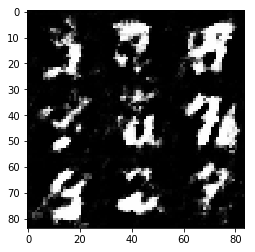

Epoch 1/2... Discriminator Loss: 1.3953... Generator Loss: 0.6534
Epoch 1/2... Discriminator Loss: 1.3218... Generator Loss: 0.6679
Epoch 1/2... Discriminator Loss: 1.2488... Generator Loss: 0.7003
Epoch 1/2... Discriminator Loss: 1.3084... Generator Loss: 0.6785
Epoch 1/2... Discriminator Loss: 1.3131... Generator Loss: 0.6564
Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 0.7133
Epoch 1/2... Discriminator Loss: 1.3013... Generator Loss: 0.6716
Epoch 1/2... Discriminator Loss: 1.2198... Generator Loss: 0.7177
Epoch 1/2... Discriminator Loss: 1.3200... Generator Loss: 0.6772
Epoch 1/2... Discriminator Loss: 1.2480... Generator Loss: 0.6957


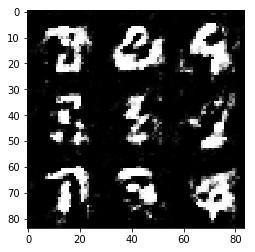

Epoch 1/2... Discriminator Loss: 1.2159... Generator Loss: 0.7413
Epoch 1/2... Discriminator Loss: 1.2469... Generator Loss: 0.7110
Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 0.7404
Epoch 1/2... Discriminator Loss: 1.2254... Generator Loss: 0.7597
Epoch 1/2... Discriminator Loss: 1.2281... Generator Loss: 0.7230
Epoch 1/2... Discriminator Loss: 1.2568... Generator Loss: 0.7524
Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 0.7859
Epoch 2/2... Discriminator Loss: 1.2008... Generator Loss: 0.7682
Epoch 2/2... Discriminator Loss: 1.1304... Generator Loss: 0.7923
Epoch 2/2... Discriminator Loss: 1.1459... Generator Loss: 0.7175


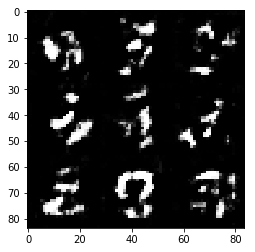

Epoch 2/2... Discriminator Loss: 1.1854... Generator Loss: 0.7295
Epoch 2/2... Discriminator Loss: 1.1698... Generator Loss: 0.7056
Epoch 2/2... Discriminator Loss: 1.1646... Generator Loss: 0.7807
Epoch 2/2... Discriminator Loss: 1.0933... Generator Loss: 0.8411
Epoch 2/2... Discriminator Loss: 1.0475... Generator Loss: 0.7837
Epoch 2/2... Discriminator Loss: 1.1058... Generator Loss: 0.7774
Epoch 2/2... Discriminator Loss: 1.0497... Generator Loss: 0.8063
Epoch 2/2... Discriminator Loss: 1.0115... Generator Loss: 0.7986
Epoch 2/2... Discriminator Loss: 1.0396... Generator Loss: 0.8864
Epoch 2/2... Discriminator Loss: 1.1454... Generator Loss: 0.6774


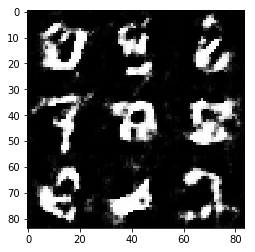

Epoch 2/2... Discriminator Loss: 1.0134... Generator Loss: 0.7924
Epoch 2/2... Discriminator Loss: 1.0950... Generator Loss: 0.7363
Epoch 2/2... Discriminator Loss: 1.0620... Generator Loss: 0.7779
Epoch 2/2... Discriminator Loss: 1.0590... Generator Loss: 0.7164
Epoch 2/2... Discriminator Loss: 1.1083... Generator Loss: 0.8622
Epoch 2/2... Discriminator Loss: 1.0124... Generator Loss: 0.9262
Epoch 2/2... Discriminator Loss: 1.0307... Generator Loss: 0.8853
Epoch 2/2... Discriminator Loss: 1.0378... Generator Loss: 0.8862
Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 0.6858
Epoch 2/2... Discriminator Loss: 1.0715... Generator Loss: 0.7043


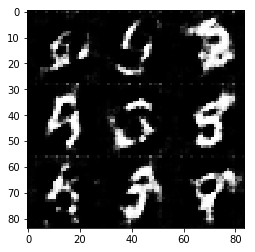

Epoch 2/2... Discriminator Loss: 1.0466... Generator Loss: 0.7843
Epoch 2/2... Discriminator Loss: 1.0332... Generator Loss: 0.8465
Epoch 2/2... Discriminator Loss: 1.0673... Generator Loss: 0.7338
Epoch 2/2... Discriminator Loss: 1.1362... Generator Loss: 0.7627
Epoch 2/2... Discriminator Loss: 1.0746... Generator Loss: 0.6978
Epoch 2/2... Discriminator Loss: 1.1102... Generator Loss: 0.7268
Epoch 2/2... Discriminator Loss: 1.1367... Generator Loss: 0.7545
Epoch 2/2... Discriminator Loss: 1.1241... Generator Loss: 0.6917
Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 0.9541
Epoch 2/2... Discriminator Loss: 1.0848... Generator Loss: 1.0362


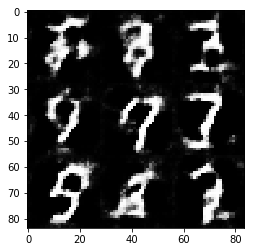

Epoch 2/2... Discriminator Loss: 1.0978... Generator Loss: 0.7931
Epoch 2/2... Discriminator Loss: 1.1225... Generator Loss: 0.7478
Epoch 2/2... Discriminator Loss: 1.1383... Generator Loss: 0.7276
Epoch 2/2... Discriminator Loss: 1.0998... Generator Loss: 0.9354
Epoch 2/2... Discriminator Loss: 1.2195... Generator Loss: 0.5534
Epoch 2/2... Discriminator Loss: 1.2126... Generator Loss: 0.8244
Epoch 2/2... Discriminator Loss: 1.0860... Generator Loss: 0.7690
Epoch 2/2... Discriminator Loss: 1.1457... Generator Loss: 0.9518
Epoch 2/2... Discriminator Loss: 1.1623... Generator Loss: 0.6719
Epoch 2/2... Discriminator Loss: 1.1161... Generator Loss: 0.9756


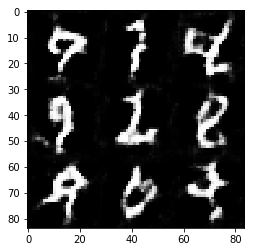

Epoch 2/2... Discriminator Loss: 1.2418... Generator Loss: 0.6432
Epoch 2/2... Discriminator Loss: 1.1710... Generator Loss: 0.6881
Epoch 2/2... Discriminator Loss: 1.1884... Generator Loss: 0.8779


In [12]:
batch_size = 128
z_dim = 200
learning_rate = 0.0001
beta1 = 0.5




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7972... Generator Loss: 0.2845
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 0.5912... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 0.7583... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 0.4678... Generator Loss: 1.8137
Epoch 1/1... Discriminator Loss: 1.5558... Generator Loss: 0.4644
Epoch 1/1... Discriminator Loss: 1.8587... Generator Loss: 0.4524
Epoch 1/1... Discriminator Loss: 0.7137... Generator Loss: 1.1395
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.1636
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 1.0322


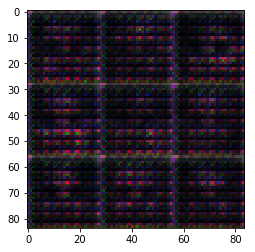

Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 0.6655... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 0.7582... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 0.4127... Generator Loss: 1.8375
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 0.5058... Generator Loss: 1.8559
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 0.8726


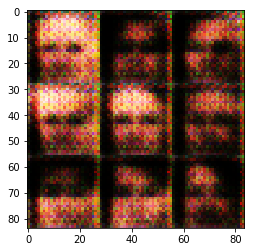

Epoch 1/1... Discriminator Loss: 0.4423... Generator Loss: 3.0149
Epoch 1/1... Discriminator Loss: 0.4109... Generator Loss: 1.6157
Epoch 1/1... Discriminator Loss: 0.4279... Generator Loss: 3.1410
Epoch 1/1... Discriminator Loss: 0.7220... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 1.7922... Generator Loss: 0.2374
Epoch 1/1... Discriminator Loss: 0.5131... Generator Loss: 1.6207
Epoch 1/1... Discriminator Loss: 2.1445... Generator Loss: 0.1831
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 1.5641
Epoch 1/1... Discriminator Loss: 0.6904... Generator Loss: 1.0591
Epoch 1/1... Discriminator Loss: 0.6307... Generator Loss: 1.3870


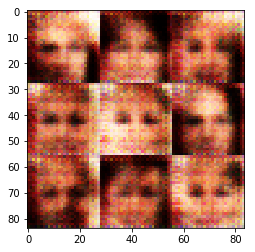

Epoch 1/1... Discriminator Loss: 0.3285... Generator Loss: 1.9700
Epoch 1/1... Discriminator Loss: 0.1618... Generator Loss: 3.7436
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.3831
Epoch 1/1... Discriminator Loss: 0.2771... Generator Loss: 2.9909
Epoch 1/1... Discriminator Loss: 0.3686... Generator Loss: 3.7778
Epoch 1/1... Discriminator Loss: 0.4519... Generator Loss: 1.2677
Epoch 1/1... Discriminator Loss: 0.4348... Generator Loss: 1.3494
Epoch 1/1... Discriminator Loss: 0.1087... Generator Loss: 3.7232
Epoch 1/1... Discriminator Loss: 0.3429... Generator Loss: 5.7841
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 7.9785


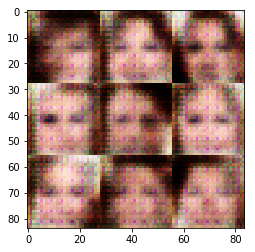

Epoch 1/1... Discriminator Loss: 0.1853... Generator Loss: 3.5894
Epoch 1/1... Discriminator Loss: 0.4423... Generator Loss: 3.4358
Epoch 1/1... Discriminator Loss: 0.4312... Generator Loss: 1.5884
Epoch 1/1... Discriminator Loss: 0.2824... Generator Loss: 3.5458
Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 0.3437... Generator Loss: 2.3743
Epoch 1/1... Discriminator Loss: 0.3410... Generator Loss: 1.5372
Epoch 1/1... Discriminator Loss: 0.6461... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 4.7529
Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 2.1667


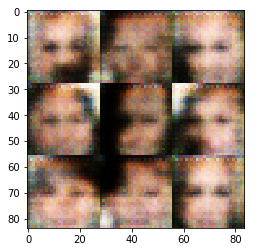

Epoch 1/1... Discriminator Loss: 0.3115... Generator Loss: 1.7873
Epoch 1/1... Discriminator Loss: 0.8156... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 1.9164
Epoch 1/1... Discriminator Loss: 0.6203... Generator Loss: 1.6277
Epoch 1/1... Discriminator Loss: 0.6055... Generator Loss: 1.2882
Epoch 1/1... Discriminator Loss: 0.3696... Generator Loss: 3.8566
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 0.5433... Generator Loss: 1.5967
Epoch 1/1... Discriminator Loss: 2.0388... Generator Loss: 0.1840


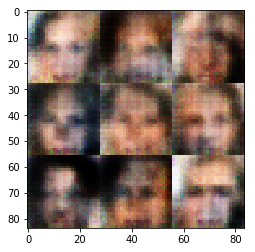

Epoch 1/1... Discriminator Loss: 0.6617... Generator Loss: 1.0687
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 0.4640... Generator Loss: 2.1938
Epoch 1/1... Discriminator Loss: 0.1964... Generator Loss: 3.8842
Epoch 1/1... Discriminator Loss: 0.7216... Generator Loss: 1.5426
Epoch 1/1... Discriminator Loss: 0.6298... Generator Loss: 0.9831
Epoch 1/1... Discriminator Loss: 0.3569... Generator Loss: 1.9731
Epoch 1/1... Discriminator Loss: 0.3244... Generator Loss: 3.5060
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.6131
Epoch 1/1... Discriminator Loss: 0.4504... Generator Loss: 3.7146


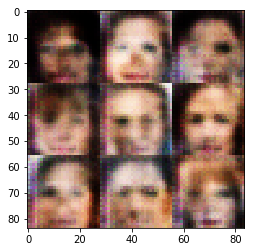

Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 2.4301
Epoch 1/1... Discriminator Loss: 0.6722... Generator Loss: 1.1268
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.4754
Epoch 1/1... Discriminator Loss: 0.5960... Generator Loss: 1.3072
Epoch 1/1... Discriminator Loss: 0.6783... Generator Loss: 1.3365
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.4261
Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 1.4960
Epoch 1/1... Discriminator Loss: 0.8772... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 0.4588... Generator Loss: 2.3320
Epoch 1/1... Discriminator Loss: 0.3655... Generator Loss: 2.7742


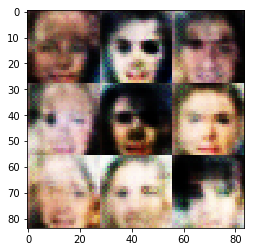

Epoch 1/1... Discriminator Loss: 0.3861... Generator Loss: 2.0397
Epoch 1/1... Discriminator Loss: 0.2417... Generator Loss: 3.5582
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 1.7022
Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 1.3714
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.4127
Epoch 1/1... Discriminator Loss: 0.6422... Generator Loss: 1.2320
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 0.8648... Generator Loss: 2.7396
Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 1.8864
Epoch 1/1... Discriminator Loss: 1.7036... Generator Loss: 0.2882


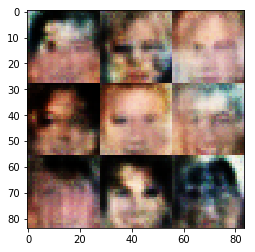

Epoch 1/1... Discriminator Loss: 0.3093... Generator Loss: 3.0716
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 1.6186
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.3467
Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.3912
Epoch 1/1... Discriminator Loss: 1.6114... Generator Loss: 0.3666
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 1.1345
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 0.6804


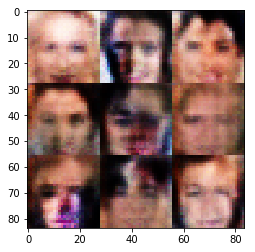

Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 0.6809... Generator Loss: 1.3958
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.7905... Generator Loss: 0.2636
Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.3380
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.5114
Epoch 1/1... Discriminator Loss: 0.7516... Generator Loss: 1.0345
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.4825
Epoch 1/1... Discriminator Loss: 0.7909... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 0.7920... Generator Loss: 0.9476


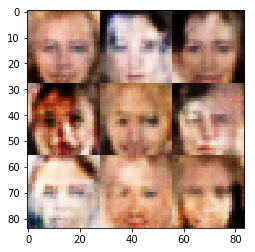

Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.2534
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 1.0748
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 1.8964
Epoch 1/1... Discriminator Loss: 0.5273... Generator Loss: 1.4908
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.5043
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 1.8839


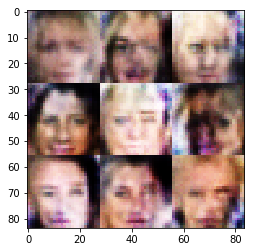

Epoch 1/1... Discriminator Loss: 0.5584... Generator Loss: 1.2965
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.9611
Epoch 1/1... Discriminator Loss: 0.6610... Generator Loss: 1.8434
Epoch 1/1... Discriminator Loss: 0.6996... Generator Loss: 1.1743
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 1.3119
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.6317... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 1.6052
Epoch 1/1... Discriminator Loss: 0.8025... Generator Loss: 1.4622
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 0.9125


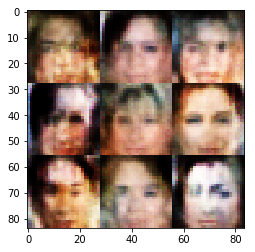

Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 1.0967
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 0.5765... Generator Loss: 1.7389
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 1.5518
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 2.6493
Epoch 1/1... Discriminator Loss: 0.7807... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 2.2290
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.9849


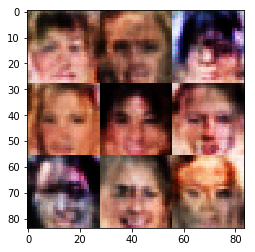

Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 0.3439
Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 1.0427
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 1.0755
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.9761
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.3766
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 1.8537
Epoch 1/1... Discriminator Loss: 0.7835... Generator Loss: 1.0691
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 0.8956


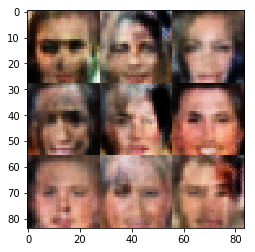

Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 1.6493
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 2.1247
Epoch 1/1... Discriminator Loss: 0.6886... Generator Loss: 2.1795
Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 0.4713... Generator Loss: 1.8588
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 0.9262


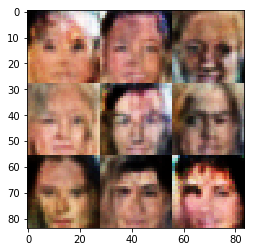

Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.3391
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 1.4116
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.4666
Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 1.0398
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 1.6630
Epoch 1/1... Discriminator Loss: 0.8072... Generator Loss: 1.9719
Epoch 1/1... Discriminator Loss: 0.5779... Generator Loss: 2.3844


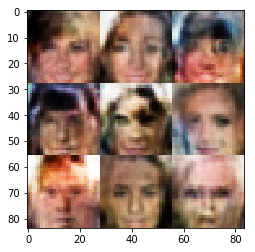

Epoch 1/1... Discriminator Loss: 1.7322... Generator Loss: 1.2095
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 1.3762
Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 1.1544
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 1.5645
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 1.2046
Epoch 1/1... Discriminator Loss: 0.5262... Generator Loss: 1.7898
Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.5966


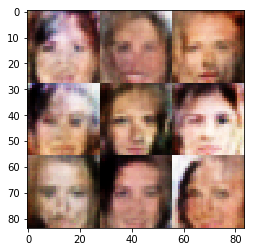

Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 1.1769
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 0.7787... Generator Loss: 1.3051
Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 1.2448
Epoch 1/1... Discriminator Loss: 1.8877... Generator Loss: 1.4071
Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.9610


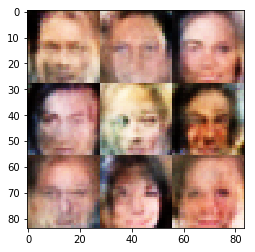

Epoch 1/1... Discriminator Loss: 0.8183... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 1.3810
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 1.4412
Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 1.0877
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 1.3301
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 1.0660
Epoch 1/1... Discriminator Loss: 0.5956... Generator Loss: 1.9343
Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.3758
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 1.2330


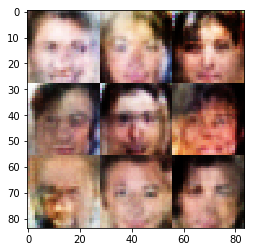

Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.4548
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 1.0886
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 0.6785... Generator Loss: 1.4253
Epoch 1/1... Discriminator Loss: 0.8933... Generator Loss: 1.1006
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 0.5828... Generator Loss: 1.2773
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 0.9761


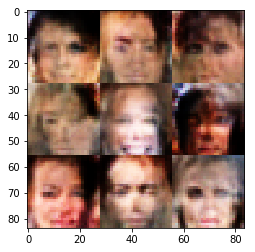

Epoch 1/1... Discriminator Loss: 0.6773... Generator Loss: 3.0126
Epoch 1/1... Discriminator Loss: 1.7063... Generator Loss: 0.3282
Epoch 1/1... Discriminator Loss: 0.5744... Generator Loss: 1.4178
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.1575
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.1412
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 1.2744
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 0.5218... Generator Loss: 1.8049


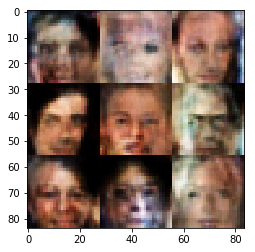

Epoch 1/1... Discriminator Loss: 0.5133... Generator Loss: 2.2783
Epoch 1/1... Discriminator Loss: 0.5737... Generator Loss: 1.6784
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 0.4539... Generator Loss: 2.9215
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 1.1734
Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.4526


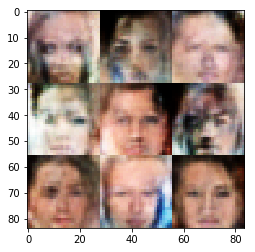

Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 1.2607
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.4586
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 1.1173
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 2.3752
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 1.2715
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 1.5123
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 0.6210... Generator Loss: 1.4936


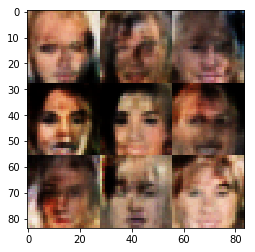

Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.4699
Epoch 1/1... Discriminator Loss: 0.8971... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 0.9891... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 0.7493... Generator Loss: 1.4476
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 1.4532
Epoch 1/1... Discriminator Loss: 0.6316... Generator Loss: 1.4094


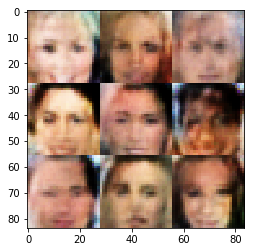

Epoch 1/1... Discriminator Loss: 0.5461... Generator Loss: 3.3003
Epoch 1/1... Discriminator Loss: 0.7941... Generator Loss: 1.4568
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 1.3559
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 1.2641
Epoch 1/1... Discriminator Loss: 0.7754... Generator Loss: 1.4966
Epoch 1/1... Discriminator Loss: 0.5659... Generator Loss: 1.9202
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 1.6441


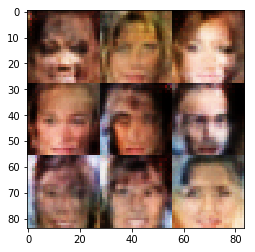

Epoch 1/1... Discriminator Loss: 1.7275... Generator Loss: 0.2968
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 0.5765... Generator Loss: 2.5962
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 1.1286
Epoch 1/1... Discriminator Loss: 0.4113... Generator Loss: 2.4024
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 1.5409
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 0.7664... Generator Loss: 1.0747


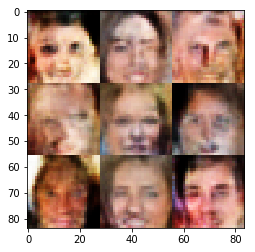

Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 0.6495... Generator Loss: 1.3637
Epoch 1/1... Discriminator Loss: 1.7699... Generator Loss: 0.3163
Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.4228
Epoch 1/1... Discriminator Loss: 1.6087... Generator Loss: 0.4008
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 1.0831


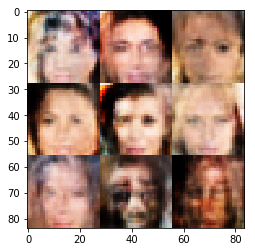

Epoch 1/1... Discriminator Loss: 0.6855... Generator Loss: 2.1655
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 1.2876
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 0.5956... Generator Loss: 2.2712
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.2513
Epoch 1/1... Discriminator Loss: 0.6714... Generator Loss: 1.7074


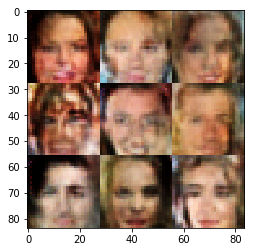

Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 1.1435
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 0.6494... Generator Loss: 1.3203
Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 1.7636
Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 1.3491
Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 1.3968
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.7579... Generator Loss: 0.2716
Epoch 1/1... Discriminator Loss: 0.3142... Generator Loss: 2.0308
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 1.1213


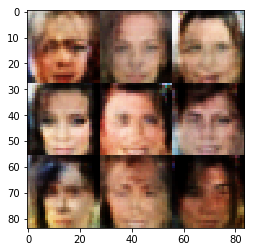

Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 0.8625... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.4144
Epoch 1/1... Discriminator Loss: 0.6123... Generator Loss: 1.2574
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.5044
Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 1.2616
Epoch 1/1... Discriminator Loss: 0.6870... Generator Loss: 1.1480


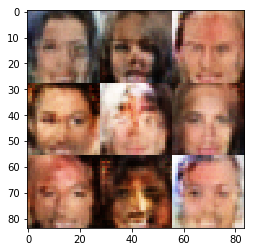

Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 0.7581... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 1.0828
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 1.0622


In [13]:
batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.